# Benchmark different file transform approaches

This document serves the purpose of improving certain time critical parts of the file creat_cube.py from the CryoCube repository on Github.

## Setup
Importing the necessary modules (run poetry install to use the environment for this)


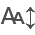

/work/le837wmue-Rhone-download/le837wmue-Rhone_download-1720747219/DAS_2020


In [1]:
############# Import the necessary modules #############
#python basemodules and jupyter modules
import os
import sys
import shutil
import multiprocessing as mp
from IPython.display import display
import re
from datetime import datetime, timedelta
from operator import itemgetter
from dotenv import load_dotenv

#benchmarking
import time
import cProfile
import pstats
import io

# data handling
import h5py
import xarray as xr
import numpy as np
import pandas as pd
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)
import scipy
from scipy import signal, fft
import dask.array as da
import pyfftw
import pyfftw.interfaces.dask_fft as dafft
import pickle
import zarr

# get the base path of the repository
repo_dir = os.popen('git rev-parse --show-toplevel').read().strip()

###load the .env file
load_dotenv(dotenv_path=f"{repo_dir}/.env")

###########get the environment vairables#########
base=os.getenv("baseFolder")
print(base)

Reading the folders and filenames

In [2]:
os.chdir(base)
folders=os.listdir()
#print(folders)
os.chdir(f"{base}/{folders[0]}")
files=os.listdir()
print("Number of files in folder 1:", len(files))
files[0:10]

Number of files in folder 1: 2880


['rhone1khz_UTC_20200715_092120.719.h5',
 'rhone1khz_UTC_20200715_075250.719.h5',
 'rhone1khz_UTC_20200715_144620.719.h5',
 'rhone1khz_UTC_20200715_193850.719.h5',
 'rhone1khz_UTC_20200715_175650.719.h5',
 'rhone1khz_UTC_20200715_044220.719.h5',
 'rhone1khz_UTC_20200715_192520.719.h5',
 'rhone1khz_UTC_20200715_045050.719.h5',
 'rhone1khz_UTC_20200715_174420.719.h5',
 'rhone1khz_UTC_20200715_193750.719.h5']

## Optimization
### Benchmarking the file read and conversion to numpy array

1. Using h5py as originally

In [7]:
start=time.time()
f=h5py.File(files[420],  'r')
dset=f['Acoustic']
array=np.array(dset)
print(array)
end=time.time()
print("Time elapsed:", end-start)

[[-9261 12804 -2517 ...   700  7029 -8943]
 [-6321  9102  1064 ... -1925  1997 -7135]
 [-1866  7452  3503 ...  1882   344  7374]
 ...
 [-3275   991  3457 ... -5936 -2816  5161]
 [-1521  6921 -4265 ... -3335 -1816  2363]
 [ 2106  2457  4822 ...  3443 -2325 10577]]
Time elapsed: 0.1787099838256836


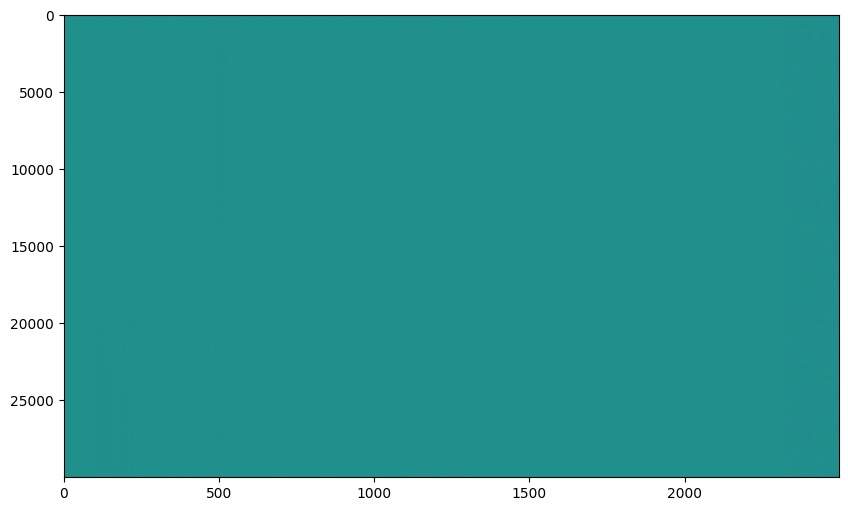

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(array, aspect='auto', cmap='viridis')

2. Using xarray. Xarray uses distributed chunked reading, so we can assume that it is faster than h5py.

In [5]:
start=time.time()
xr_h5=xr.open_dataset(files[420], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'}) # we need to pass phony_dims as the file has no xarray readable dimensions
array=xr_h5["Acoustic"].compute().values
print(array)
end=time.time()
print("Time elapsed:", end-start)

[[-9261 12804 -2517 ...   700  7029 -8943]
 [-6321  9102  1064 ... -1925  1997 -7135]
 [-1866  7452  3503 ...  1882   344  7374]
 ...
 [-3275   991  3457 ... -5936 -2816  5161]
 [-1521  6921 -4265 ... -3335 -1816  2363]
 [ 2106  2457  4822 ...  3443 -2325 10577]]
Time elapsed: 0.3443334102630615


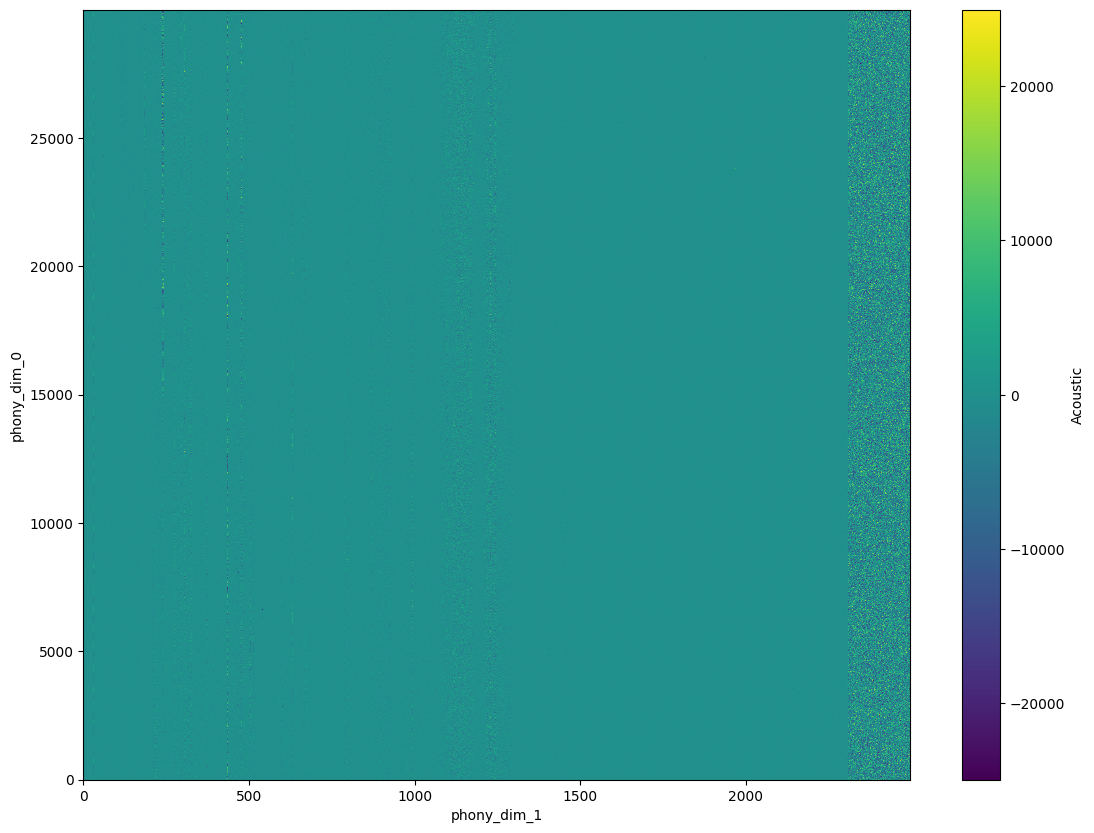

In [6]:
xr_h5["Acoustic"].compute().plot(size=10, aspect='auto', cmap='viridis')

Reading a single file, xarray is about 3 hundredths faster than h5py. Let's see if this scales:

In [7]:
start=time.time()
for index,file in enumerate(files[0:40]):
    f=h5py.File(files[index],  'r')
    dset=f['Acoustic']
    np.array(dset)
end=time.time()
print("Time elapsed:", end-start)

Time elapsed: 20.774585962295532


In [8]:
start=time.time()
for index,file in enumerate(files[0:40]):
    xr_h5=xr.open_dataset(files[index], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
    xr_h5["Acoustic"].compute().values
end=time.time()
print("Time elapsed:", end-start)

Time elapsed: 3.6368637084960938


It does! Reading 40 files with h5py takes 17.9 seconds, with xarray it takes 2.9 seconds.
Can we use multiprocessing to speed up the process?

In [10]:
cpu_count=mp.cpu_count()*2//3 # we take two thirds so the open file limit is not exceeded
cpu_count

85

In [11]:
def read_file(file):
    with h5py.File(file, 'r') as f: # we need with so it actually closes
        dset = f['Acoustic']
        np.array(dset)

start=time.time()
pool=mp.Pool(cpu_count)
pool.map(read_file, files[0:40])
pool.close()
pool.join()
end=time.time()
print("Time elapsed:", end-start) 

Time elapsed: 2.7098798751831055


In [12]:
def read_file(file):
    xr_h5=xr.open_dataset(file, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
    xr_h5["Acoustic"].compute().values

start=time.time()
pool=mp.Pool(cpu_count)
pool.map(read_file, files[0:40])
pool.close()
pool.join()
end=time.time()
print("Time elapsed:", end-start) 

Time elapsed: 2.3454315662384033


Xarray with the underlying dask is already using distributed computing. Still, we see that we can improve the reading and conversion to 1.78 seconds. 
However, h5py's conversion time is also highly reduced to only 2.54 seconds. Let's try it with more files:

In [13]:
def read_file(file):
    with h5py.File(file, 'r') as f: # we need with so it actually closes
        dset = f['Acoustic']
        np.array(dset)

start=time.time()
pool=mp.Pool(mp.cpu_count())
pool.map(read_file, files[0:200])
pool.close()
pool.join()
end=time.time()
print("Time elapsed:", end-start) 

Time elapsed: 17.663760662078857


In [14]:
def read_file(file):
    xr_h5=xr.open_dataset(file, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
    xr_h5["Acoustic"].compute().values

start=time.time()
pool=mp.Pool(cpu_count)
pool.map(read_file, files[0:200])
pool.close()
pool.join()
end=time.time()
print("Time elapsed:", end-start) 

Time elapsed: 15.217929363250732


As we can see, this scales, although only by a small amount of 2.5 seconds on 200 files. Still, we can use it for improvement.

### Benchmarking different approaches to the Fourier transformation

1. The original approach 

In [18]:
##########Base settings#########
#granularity of spectrogram
d_f = 1 # frequency resolution in Hz
d_t = 0.1 # time res in seconds

# section
loc_a, loc_e = 0, 9200 # cable section to be processed (in meters) - 0==start
ind_a, ind_e= loc_a//4, loc_e//4 # channel distances (4m each)
nFiles = 5 # number of h5 files processed
nCores = 8 # cpu cores


day= 22
month=7
sec=0
minut=0
hours=0

# Additional parameters:
file_length = 30 # Length of a single h5 file in seconds.
NU = 1000 #Sampling frequency in Hz of the recorded data.
freq_max = 100 # maximum frequency cut off value for the analysis
seg_length=1/d_f #calculate window length corresponding to d_f
N = file_length*NU #number of samples in one file
ind_f = int(seg_length*freq_max+1)
seg_len=int(seg_length*NU) #how many time points should be in one processing window
nseg=int(2*(file_length/seg_length)) #amount of segments for the desired window length
location_coords = np.arange(loc_a, loc_e, 4)
freq_coords=scipy.fft.rfftfreq(int(NU/d_f), 1/NU)[:ind_f]
hop = int(d_t*NU)

#fft input arguments
args = {
    "ind_f" : ind_f,
    "ind_a" : ind_a,
    "ind_e" : ind_e,
    "seg_len" : seg_len,
    "hop" : hop,
    "N" : N
}


#path and name of resulting zarr-formatted data cube.
ZARR_NAME = "cryo_cube.zarr"

def channel_fourier_numpy(data, args, taper, positions):
    """
    Applies Fourier Transformation to segments of DAS records to compute spectrograms.

    Args:
        data (ndarray): The raw data from DAS channels.
        args (dict): Contains parameters for Fourier Transform such as segment length and indices.
        taper (ndarray): The taper function to apply before the Fourier transform.
        positions (ndarray): The positions of the segments.

    Returns:
        ndarray: A 3D array containing the Fourier transform for each segment and channel.
    """
    seg_len = args["seg_len"]
    ind_e, ind_a = args["ind_e"], args["ind_a"]
    ind_f = args["ind_f"]



    # data transformation
    segs = ([data[pos:pos+seg_len] for pos in positions]) #dividing the data into segments each consisting of desired amount of data points
    segs = [seg.T[ind_a:ind_e] for seg in segs] #transposing the segments individually to gain time series for each channel
    nseg = positions.shape[0]
    
    # the first loop iterates over all segments (each corresponding to a time point)
    # in the second loop, the fourier transform gets applied on each channel
    Fsegs=np.zeros((nseg, ind_e-ind_a, ind_f))
    for i in range(nseg):
        for channel_number, channel in enumerate(segs[i]):

            # note that modified_log(x)=10*log(x) (conversion to

            fourier_transformed = np.fft.rfft(taper*channel, n=seg_len)
            fourier_transformed = ((10*np.log(np.abs(fourier_transformed)**2)))[0:ind_f]
            fourier_transformed[0]=0
            Fsegs[i][channel_number]=fourier_transformed

    return Fsegs


####### running for only 
file_index=0
f=h5py.File(files[file_index],  'r')
dset=f['Acoustic']
seg_len=args["seg_len"]
hop=args["hop"]
N=args["N"]
data = np.array(dset) # DAS data
taper = signal.windows.tukey(seg_len, 0.25) #taper function - reduce the amplitude of the discontinuities at the boundaries, thereby reducing spectral leakage.


# the windowing function (Tukey window in this case) tapers at the ends, 
#so to avoid losing data at the ends of each file, 
# the end of one file is overlapped with the beginning of the next file.
if file_index!=nFiles-1:

    g = h5py.File(files[file_index+1],'r')
    dset2=g['Acoustic']
    data2= np.array(dset2)
    data = np.concatenate((data, data2[0:seg_len]), axis=0)

j = file_index+1
file_pos = file_index * N

start=time.time()

# If the current file is not the last one
if file_index != nFiles-1:
    # Calculate the starting positions of each segment in the data
    # first segment: (j-1)*N/hop, rounded up
    # last segment: (j*N-1)/hop, rounded down
    positions = np.arange(np.ceil((j-1)*N/hop), np.floor((j*N-1)/hop)+1, dtype=int)*hop - file_pos # scaled by the hop size and offset by the file position
else:
    # If last one, start: (j*N-seg_len)/hop
    # to ensure that the last segment doesn't extend beyond the end of the data
    positions = np.arange(np.ceil((j-1)*N/hop), np.floor((j*N-seg_len)/hop)+1, dtype=int)*hop - file_pos
    
Fsegs = channel_fourier_numpy(data, args, taper, positions)

end=time.time()
print("Time elapsed for numpy fft:", end-start) 

Time elapsed for numpy fft: 17.54081106185913


2. Benchmarking SciPy NumPy pyFFTW

In [ ]:
def channel_fourier(data, args, taper, positions, method='numpy'):
    """
    Applies Fourier Transformation to segments of DAS records using specified method.

    Args:
        data (ndarray): The raw data from DAS channels.
        args (dict): Contains parameters for Fourier Transform such as segment length and indices.
        taper (ndarray): The taper function to apply before the Fourier transform.
        positions (ndarray): The positions of the segments.
        method (str): Method for FFT computation ('numpy', 'scipy', 'pyfftw'). Default is 'numpy'.

    Returns:
        ndarray: A 3D array containing the Fourier transform for each segment and channel.
    """
    seg_len = args["seg_len"]
    ind_e, ind_a = args["ind_e"], args["ind_a"]
    ind_f = args["ind_f"]

    segs = ([data[pos:pos+seg_len] for pos in positions])
    segs = [seg.T[ind_a:ind_e] for seg in segs]

    nseg = positions.shape[0]
    Fsegs = np.zeros((nseg, ind_e-ind_a, ind_f))

    if method == 'numpy':
        for i in range(nseg):
            for channel_number, channel in enumerate(segs[i]):
                fourier_transformed = np.fft.rfft(taper * channel, n=seg_len)
                fourier_transformed = ((10 * np.log(np.abs(fourier_transformed) ** 2)))[0:ind_f]
                fourier_transformed[0] = 0
                Fsegs[i][channel_number] = fourier_transformed

    elif method == 'scipy':
        for i in range(nseg):
            for channel_number, channel in enumerate(segs[i]):
                fourier_transformed = fft.fft(taper * channel, n=seg_len)
                fourier_transformed = ((10 * np.log(np.abs(fourier_transformed) ** 2)))[0:ind_f]
                fourier_transformed[0] = 0
                Fsegs[i][channel_number] = fourier_transformed


    elif method == 'pyfftw':
        
        # Pre-allocate the input and output arrays for FFTW
        fft_input = pyfftw.empty_aligned(seg_len, dtype='complex128')
        fft_output = pyfftw.empty_aligned(seg_len, dtype='complex128')

        # Create FFTW object
        fft_object = pyfftw.FFTW(fft_input, fft_output)

        for i in range(nseg):
            for channel_number, channel in enumerate(segs[i]):
                fft_input[:] = taper * channel  # Apply taper
                fft_object()  # Execute FFT
                fourier_transformed = ((10 * np.log(np.abs(fft_output) ** 2)))[0:ind_f]
                fourier_transformed[0] = 0
                Fsegs[i][channel_number] = fourier_transformed

    else:
        raise ValueError("Invalid method specified. Choose from 'numpy', 'scipy', or 'pyfftw'.")

    return Fsegs

In [ ]:
# Assuming 'files' is a list of file paths and 'nFiles' is the total number of files
nFiles = 5  # Set this to the actual number of files you want to process
methods = ['numpy', 'scipy', 'pyfftw']  # FFT methods to benchmark
#methods = ['pyfftw']
#methods = ['scipy']
# methods = ['numpy']

# Loop over each method first
for method in methods:
    print(f"Benchmarking method: {method}")
    # Then loop over each file for the current method
    for file_index in range(nFiles):
        seg_len = args["seg_len"]
        hop = args["hop"]
        N = args["N"]

        f = h5py.File(files[file_index], 'r')
        dset = f['Acoustic']
        data = np.array(dset)

        taper = signal.windows.tukey(seg_len, 0.25)

        if file_index != nFiles - 1:
            g = h5py.File(files[file_index + 1], 'r')
            dset2 = g['Acoustic']
            data2 = np.array(dset2)
            data = np.concatenate((data, data2[0:seg_len]), axis=0)

        j = file_index + 1
        file_pos = file_index * N

        if file_index != nFiles - 1:
            positions = np.arange(np.ceil((j - 1) * N / hop), np.floor((j * N - 1) / hop) + 1, dtype=int) * hop - file_pos
        else:
            positions = np.arange(np.ceil((j - 1) * N / hop), np.floor((j * N - seg_len) / hop) + 1, dtype=int) * hop - file_pos

        # Benchmark the current method for the current file
        start = time.time()
        Fsegs = channel_fourier(data, args, taper, positions, method=method)
        end = time.time()
        print(f"Time elapsed for {method} fft in file {file_index}:", end - start)

Benchmarking method: pyfftw
Found a wisdom file.
Time elapsed for pyfftw fft in file 0: 29.261847496032715
Found a wisdom file.
Time elapsed for pyfftw fft in file 1: 28.909889459609985
Found a wisdom file.
Time elapsed for pyfftw fft in file 2: 29.205402135849
Found a wisdom file.
Time elapsed for pyfftw fft in file 3: 29.085736751556396
Found a wisdom file.
Time elapsed for pyfftw fft in file 4: 28.201012134552002


### Optimizing pyFFTW

#### Using rfft from the builders module of pyFFTW
With the simple setup above, pyFFTW and scipy.fft both performed worse than the numpy implementation. However, there is room for improvement of pyFFTW, which is given the name by the original algorithm Fastest Fourier Transform in the West from the corresponding researchers at MIT.

Originally RFFT was applied via numpy, we can do the same with the builders model from pyFFTW (a c wrapper for FFTW in python).
The "FFTW_ESTIMATE" flag estimates the best method instead of measuring it - this can bring some performance. In our case however, it doesnt and for more accuracy we take the measured default. Also confguring multithreading with pyfftw.config.NUM_THREADS = 8 actually leads to about a second worse performance than the standard implementation with a single thread. Suprisingly, also the suage of a wisdom file for the FFTW object creation slows the process by 0.5 seconds, so we use the most simple default setup.
Overall we see an improvement of 3 seconds to the original numpy function per file. This of course scales when using a total of 1300 files per folder.

In [19]:
def channel_fourier(data, args, taper, positions):
    """
    Applies Fourier Transformation to segments of DAS records using specified method.

    Args:
        data (ndarray): The raw data from DAS channels.
        args (dict): Contains parameters for Fourier Transform such as segment length and indices.
        taper (ndarray): The taper function to apply before the Fourier transform.
        positions (ndarray): The positions of the segments.
        method (str): Method for FFT computation ('numpy', 'scipy', 'pyfftw'). Default is 'numpy'.

    Returns:
        ndarray: A 3D array containing the Fourier transform for each segment and channel.
    """
    seg_len = args["seg_len"]
    ind_e, ind_a = args["ind_e"], args["ind_a"]
    ind_f = args["ind_f"]

    segs = ([data[pos:pos+seg_len] for pos in positions])
    segs = [seg.T[ind_a:ind_e] for seg in segs]

    nseg = positions.shape[0]
    Fsegs = np.zeros((nseg, ind_e-ind_a, ind_f))

    # Pre-allocate the input array for FFTW
    fft_input = pyfftw.empty_aligned(seg_len, dtype='float64')

    # Create FFTW object
    fft_object = pyfftw.builders.rfft(fft_input)#, planner_effort='FFTW_ESTIMATE') #, threads=mp.cpu_count()//2)

    for i in range(nseg):
        for channel_number, channel in enumerate(segs[i]):
            fft_input[:] = taper * channel  # Apply taper
            fft_output = fft_object()  # Execute FFT
            fourier_transformed = ((10 * np.log(np.abs(fft_output) ** 2)))[0:ind_f] # Compute power spectrum
            fourier_transformed[0] = 0 # Remove DC component (average value of the signal)
            Fsegs[i][channel_number] = fourier_transformed

    return Fsegs


In [20]:
file_index=0
seg_len = args["seg_len"]
hop = args["hop"]
N = args["N"]

f = h5py.File(files[file_index], 'r')
dset = f['Acoustic']
data = np.array(dset)

taper = signal.windows.tukey(seg_len, 0.25)

if file_index != nFiles - 1:
    g = h5py.File(files[file_index + 1], 'r')
    dset2 = g['Acoustic']
    data2 = np.array(dset2)
    data = np.concatenate((data, data2[0:seg_len]), axis=0)

j = file_index + 1
file_pos = file_index * N

if file_index != nFiles - 1:
    positions = np.arange(np.ceil((j - 1) * N / hop), np.floor((j * N - 1) / hop) + 1, dtype=int) * hop - file_pos
else:
    positions = np.arange(np.ceil((j - 1) * N / hop), np.floor((j * N - seg_len) / hop) + 1, dtype=int) * hop - file_pos

# Benchmark the current method for the current file
start = time.time()
Fsegs = channel_fourier(data, args, taper, positions)
end = time.time()
print(f"Time elapsed for pyFFTW rfft in file {file_index}:", end - start)

Time elapsed for pyFFTW rfft in file 0: 14.436076164245605


#### Using dask via pyFFTW
This is a very ineffciient implementation of dask to calculate the fft. The calculation therefore takes minutes to complete. There might however be more promising setups with Dask.

In [4]:
def channel_fourier(data, args, taper, positions):
    
    # Enable the pyfftw cache
    pyfftw.interfaces.cache.enable()
    start=time.time()
    seg_len = args["seg_len"]
    ind_e, ind_a = args["ind_e"], args["ind_a"]
    ind_f = args["ind_f"]

    segs = ([data[pos:pos+seg_len] for pos in positions])
    segs = [seg.T[ind_a:ind_e] for seg in segs]

    nseg = positions.shape[0]
    Fsegs = np.zeros((nseg, ind_e-ind_a, ind_f))
    step1=time.time()
    print("Time to create segments: ", step1-start)
    for i in range(nseg):
        print("time to calculate segment", time.time()-step1)
        for channel_number, channel in enumerate(segs[i]):
            # Convert the channel data to a Dask array
            channel_da = da.from_array(channel, chunks=seg_len)
            
            # Apply taper and compute FFT using pyFFTW
            fft_output = dafft.rfft(taper * channel_da).compute()
            
            # Compute the result
            fourier_transformed = ((10 * np.log(np.abs(fft_output) ** 2)))[0:ind_f]
            fourier_transformed[0] = 0
            Fsegs[i][channel_number] = fourier_transformed
    return Fsegs

In [10]:
# Assuming 'files' is a list of file paths and 'nFiles' is the total number of files
nFiles = 2  # Set this to the actual number of files you want to process
#methods = ['numpy', 'scipy', 'pyfftw']  # FFT methods to benchmark
methods = ['pyfftw']
#methods = ['scipy']
# methods = ['numpy']

# Loop over each method first
for method in methods:
    print(f"Benchmarking method: {method}")
    # Then loop over each file for the current method
    for file_index in range(nFiles):
        seg_len = args["seg_len"]
        hop = args["hop"]
        N = args["N"]

        f = h5py.File(files[file_index], 'r')
        dset = f['Acoustic']
        data = np.array(dset)

        taper = signal.windows.tukey(seg_len, 0.25)

        if file_index != nFiles - 1:
            g = h5py.File(files[file_index + 1], 'r')
            dset2 = g['Acoustic']
            data2 = np.array(dset2)
            data = np.concatenate((data, data2[0:seg_len]), axis=0)

        j = file_index + 1
        file_pos = file_index * N

        if file_index != nFiles - 1:
            positions = np.arange(np.ceil((j - 1) * N / hop), np.floor((j * N - 1) / hop) + 1, dtype=int) * hop - file_pos
        else:
            positions = np.arange(np.ceil((j - 1) * N / hop), np.floor((j * N - seg_len) / hop) + 1, dtype=int) * hop - file_pos

        # Benchmark the current method for the current file
        start = time.time()
        Fsegs = channel_fourier(data, args, taper, positions, method=method)
        end = time.time()
        print(f"Time elapsed for {method} fft in file {file_index}:", end - start)

Benchmarking method: pyfftw
Time to create segments:  0.0002827644348144531
time to calculate segment 9.608268737792969e-05
time to calculate segment 7.6081647872924805
time to calculate segment 15.087376594543457
time to calculate segment 22.52371120452881
time to calculate segment 30.099513053894043
time to calculate segment 37.775598764419556
time to calculate segment 45.30102229118347
time to calculate segment 52.911967515945435
time to calculate segment 60.48925495147705
time to calculate segment 68.05755162239075
time to calculate segment 75.67105388641357
time to calculate segment 83.3500165939331
time to calculate segment 91.00610542297363
time to calculate segment 98.66999650001526
time to calculate segment 106.36303210258484
time to calculate segment 114.03694224357605
time to calculate segment 121.70337414741516


KeyboardInterrupt: 

3. GPU-based method: Cuda FFT

In [ ]:
# some cuda approach

### Comparison of the improvements to the point

Let's summarize our improvements so far and compare them together with the original setup:
1. Reading with Xarray instead of  h5py
2. Using pyFFTW with the builders module for the rfft

#### Setting up new combined functions for the improvements 

In [21]:
##########Base settings#########
#granularity of spectrogram
freq_res = 1 # frequency resolution in Hz
time_res = 0.1 # time res in seconds

# section
cable_start, cable_end = 0, 9200 # cable section to be processed (in meters) - 0==start
start_channel_index, end_channel_index= cable_start // 4 , cable_end // 4 # channel distances (4m each)
n_files = 5 # number of h5 files processed
n_cores = 8 # cpu cores


day= 22
month=7
sec=0
minut=0
hours=0

# Additional parameters:
file_length = 30 # Length of a single h5 file in seconds.
sample_freq = 1000 #Sampling frequency in Hz of the recorded data.
freq_max = 100 # maximum frequency cut off value for the analysis
seg_length=1/freq_res #calculate window length corresponding to freq_res
n_samples = file_length*sample_freq #number of samples in one file
num_frequency_points = int(seg_length*freq_max+1)
seg_len=int(seg_length*sample_freq) #how many time points should be in one processing window
n_segments=int(2*(file_length/seg_length)) #amount of segments for the desired window length
location_coords = np.arange(cable_start, cable_end, 4)
freq_coords=scipy.fft.rfftfreq(int(sample_freq/freq_res), 1/sample_freq)[:num_frequency_points]
hop = int(time_res*sample_freq)

#fft input arguments
args = {
    "num_frequency_points" : num_frequency_points,
    "start_channel_index" : start_channel_index,
    "end_channel_index" : end_channel_index,
    "seg_len" : seg_len,
    "hop" : hop,
    "n_samples" : n_samples
}


#path and name of resulting zarr-formatted data cube.
ZARR_NAME = "cryo_cube.zarr"

def channel_fourier(data, args, taper, positions, method='numpy'):
    """
    Applies Fourier Transformation to segments of DAS records using specified method.

    Args:
        data (ndarray): The raw data from DAS channels.
        args (dict): Contains parameters for Fourier Transform such as segment length and indices.
        taper (ndarray): The taper function to apply before the Fourier transform.
        positions (ndarray): The positions of the segments.
        method (str): Method for FFT computation ('numpy', 'scipy', 'pyfftw'). Default is 'numpy'.

    Returns:
        ndarray: A 3D array containing the Fourier transform for each segment and channel.
    """
    seg_len = args["seg_len"]
    end_channel_index, start_channel_index = args["end_channel_index"], args["start_channel_index"]
    num_frequency_points = args["num_frequency_points"]

    segments = ([data[pos:pos+seg_len] for pos in positions])
    segments = [seg.T[start_channel_index:end_channel_index] for seg in segments]

    n_segments = positions.shape[0]
    Fsegs = np.zeros((n_segments, end_channel_index-start_channel_index, num_frequency_points))

    if method=="pyfftw":
        # Pre-allocate the input array for FFTW
        fft_input = pyfftw.empty_aligned(seg_len, dtype='float64')
        # Create FFTW object
        fft_object = pyfftw.builders.rfft(fft_input)#, planner_effort='FFTW_ESTIMATE') #, threads=mp.cpu_count()//2)

        for i in range(n_segments):
            for channel_number, channel in enumerate(segments[i]):
                fft_input[:] = taper * channel  # Apply taper
                fft_output = fft_object()  # Execute FFT
                fourier_transformed = ((10 * np.log(np.abs(fft_output) ** 2)))[0:num_frequency_points] # Compute power spectrum
                fourier_transformed[0] = 0 # Remove DC component (average value of the signal)
                Fsegs[i][channel_number] = fourier_transformed
    elif method=="numpy":
        for i in range(n_segments):
            for channel_number, channel in enumerate(segments[i]):

                # note that modified_log(x)=10*log(x) (conversion to

                fourier_transformed = np.fft.rfft(taper*channel, n=seg_len)
                fourier_transformed = ((10*np.log(np.abs(fourier_transformed)**2)))[0:num_frequency_points]
                fourier_transformed[0]=0
                Fsegs[i][channel_number]=fourier_transformed
    else:
        print("method must be one of 'numpy' or 'pyfftw'")
        
    return Fsegs



def create_spectro_segment(file_index, args, filelist, method='h5py', fft_method='numpy'):
    # chunk args
    seg_len=args["seg_len"]
    hop=args["hop"]
    n_samples=args["n_samples"]
    filename=filelist[file_index]
    
    #taper function
    taper = signal.windows.tukey(seg_len, 0.25)  # reduces the amplitude of the discontinuities at the boundaries, thereby reducing spectral leakage.
    
    data=[]
    if method=="xarray":
        xr_h5=xr.open_dataset(filename, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
        data=xr_h5["Acoustic"].compute().values
        
        # the windowing function (Tukey window in this case) tapers at the ends, 
        # to avoid losing data at the ends of each file, 
        # the end of one file is overlapped with the beginning of the next file.
        if file_index!=n_files-1:
            xr_h5_2=xr.open_dataset(filelist[file_index+1], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
            data_2=xr_h5_2["Acoustic"].compute().values
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    elif method=="h5py":
        h5file=h5py.File(filename,  'r')
        dset=h5file['Acoustic']
        data=np.array(dset) # DAS data
        
        if file_index!=n_files-1:
            h5file_2 = h5py.File(files[file_index+1],'r')
            dset_2=h5file_2['Acoustic']
            data_2= np.array(dset_2)
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    else:
        print("method must be one of 'numpy' or 'pyfftw'")
    

    next_file_index = file_index+1
    file_pos = file_index * n_samples

    # If the current file is not the last one
    if file_index != n_files-1:
        # Calculate the starting positions of each segment in the data
        # first segment: (next_file_index-1)*n_samples/hop, rounded up
        # last segment: (next_file_index*n_samples-1)/hop, rounded down
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-1)/hop)+1, dtype=int)*hop - file_pos # scaled by the hop size and offset by the file position
    else:
        # If last one, start: (next_file_index*n_samples-seg_len)/hop
        # to ensure that the last segment doesn't extend beyond the end of the data
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-seg_len)/hop)+1, dtype=int)*hop - file_pos

    Fsegs = channel_fourier(data, args, taper, positions, method=fft_method)
    return Fsegs, positions.shape[0]

#### Profile the code to see further bottlenecks

In [23]:
def profile_function(method, fft_method, file_index):
    # This function will be profiled
    Fsegs, n_segments = create_spectro_segment(file_index, args, files, method=method, fft_method=fft_method)
    print("Method:".format(method, fft_method))
    print("Number of segments:", n_segments)
    print("Shape of the resulting array:", Fsegs.shape)
    return Fsegs
    
def run_profiler(file_index, run_method=None):
    # Run the function with different methods
    methods = [['h5py', 'numpy'], ['xarray', 'pyfftw']]
    if run_method:
        methods = [method for method in methods if method ==run_method]
    Fsegs={}
    for method, fft_method in methods:
        profiler = cProfile.Profile() # Create a profiler object
        # Profile the function
        profiler.enable()
        start=time.time()
        methodname = f"{method}_{fft_method}"
        Fsegs[methodname] = profile_function(method, fft_method, file_index)
        end=time.time()
        print(f"Time elapsed for {methodname}:", end-start)
        profiler.disable()
        
        # Print profiling results
        s = io.StringIO()
        ps = pstats.Stats(profiler, stream=s).sort_stats('cumulative')
        ps.print_stats()
        
        # Adjusted parsing logic
        output_lines = s.getvalue().split('\n')
        rows = []
        for line in output_lines:
            cols = line.split(maxsplit=5)  # This assumes the first 5 columns do not contain spaces that should be preserved
            if len(cols) > 5 and cols[0].replace('.', '', 1).isdigit():
                rows.append(cols)
        df_columns = ['ncalls', 'tottime', 'percall', 'cumtime', 'percall_again', 'filename:lineno(function)']
        df = pd.DataFrame(rows, columns=df_columns)
        df = df.iloc[1:]
        print(f"Profiling results for {methodname}:")
        show(df)
    if (len(methods)>1):
        difference = Fsegs[f'{methods[0][0]}_{methods[0][1]}'] - Fsegs[f'{methods[1][0]}_{methods[1][1]}']
        print("Total difference between the two arrays:", np.sum(difference))
        print("Mean difference between the two arrays:", np.mean(difference))
        print("Max difference between the two arrays:", np.max(difference))
        print("Difference array:")
        display(difference[0:1])
        print(f"Array from {methods[0][0]}_{methods[0][1]}:") 
        display(Fsegs[f'{methods[0][0]}_{methods[0][1]}'][0:1])

In [24]:
run_profiler(0)

Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for h5py_numpy: 20.95348286628723
Profiling results for h5py_numpy:


Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 15.509725570678711
Profiling results for xarray_pyfftw:


Total difference between the two arrays: 1.3914743468568247e-08
Mean difference between the two arrays: 1.9966628596022738e-16
Max difference between the two arrays: 6.629008453273855e-10
Difference array:


array([[[ 0.00000000e+00,  0.00000000e+00, -2.84217094e-14, ...,
          0.00000000e+00, -2.84217094e-14,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00, -2.84217094e-14,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.84217094e-14,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          2.84217094e-14,  0.00000000e+00, -2.84217094e-14]]])

Array from h5py_numpy:


array([[[  0.        , 244.03235178, 225.49809319, ..., 240.37106488,
         240.78960892, 211.10645372],
        [  0.        , 247.71849101, 230.10896489, ..., 227.52306532,
         249.30927413, 230.19335816],
        [  0.        , 237.09137096, 238.30806423, ..., 243.81252942,
         241.7446133 , 227.74034111],
        ...,
        [  0.        , 143.6621595 , 132.55932437, ..., 162.76128189,
         173.00944457, 150.01853298],
        [  0.        , 137.15473521, 138.13853644, ..., 130.30652159,
         136.50079718, 165.98983174],
        [  0.        , 141.18006197, 131.49767235, ..., 131.27768692,
         149.78097395, 132.48682159]]])

### Further optimization based on the function profiling

From the profiling, we see, that pyFFTW and xarray with chunked data reading already improve the performance on the single calls. Xarray has a lot of calls that make up about half a second. However, we see the cumulative time of the upper fucntion call not increasing, indicating that the distributed loading in parallel works. The main bottleneck remaining seems to be the FFT functions still. As pyFFTW is a c-wrapper, we dont see the time consumption directly here, except for the channel_fourier time.

We can still try four optimizations of the pyFFTW input in the following:
1. Inplace operations for the pyFFTW tapered input (this approach we could only get to work with fixed segments however, this cuts the output into 15 seconds gaps. The hidden cell shows this approach)
2. Setting and changing the data type for the pyFFTW input 
    --> Initially it wasnt set at all. When setting to float64 it shows the best accuracy but only 4 seconds improvement, when setting to float32, the overall improvement is 10 seconds to the original approach.
3. Prevent division by zero problems by log smoothing with + 1e-10
4. Using a wisdom file when calling pyFFTW more often

Let's try the first three:
#### Inplace pyFFTW tapered input, log smoothing and data type for the pyFFTW input

In [27]:
##########Base settings#########
#granularity of spectrogram
freq_res = 1 # frequency resolution in Hz
time_res = 0.1 # time res in seconds

# section
cable_start, cable_end = 0, 9200 # cable section to be processed (in meters) - 0==start
start_channel_index, end_channel_index= cable_start // 4 , cable_end // 4 # channel distances (4m each)
n_files = 5 # number of h5 files processed
n_cores = 8 # cpu cores


day= 22
month=7
sec=0
minut=0
hours=0

# Additional parameters:
file_length = 30 # Length of a single h5 file in seconds.
sample_freq = 1000 #Sampling frequency in Hz of the recorded data.
freq_max = 100 # maximum frequency cut off value for the analysis
seg_length=1/freq_res #calculate window length corresponding to freq_res
n_samples = file_length*sample_freq #number of samples in one file
num_frequency_points = int(seg_length*freq_max+1)
seg_len=int(seg_length*sample_freq) #how many time points should be in one processing window
n_segments=int(2*(file_length/seg_length)) #amount of segments for the desired window length
location_coords = np.arange(cable_start, cable_end, 4)
freq_coords=scipy.fft.rfftfreq(int(sample_freq/freq_res), 1/sample_freq)[:num_frequency_points]
hop = int(time_res*sample_freq)

#fft input arguments
args = {
    "num_frequency_points" : num_frequency_points,
    "start_channel_index" : start_channel_index,
    "end_channel_index" : end_channel_index,
    "seg_len" : seg_len,
    "hop" : hop,
    "n_samples" : n_samples
}


#path and name of resulting zarr-formatted data cube.
ZARR_NAME = "cryo_cube.zarr"

def channel_fourier(data, args, taper, positions, method='numpy'):
    """
    Applies Fourier Transformation to segments of DAS records using specified method.

    Args:
        data (ndarray): The raw data from DAS channels.
        args (dict): Contains parameters for Fourier Transform such as segment length and indices.
        taper (ndarray): The taper function to apply before the Fourier transform.
        positions (ndarray): The positions of the segments.
        method (str): Method for FFT computation ('numpy', 'scipy', 'pyfftw'). Default is 'numpy'.

    Returns:
        ndarray: A 3D array containing the Fourier transform for each segment and channel.
    """
    
    # Unpack the arguments
    seg_len = args["seg_len"]
    end_channel_index, start_channel_index = args["end_channel_index"], args["start_channel_index"]
    num_frequency_points = args["num_frequency_points"]
    fft_dtype = 'float32'
    n_segments = positions.shape[0]

    Fsegs=None
    if method=="pyfftw":
        # Pre-allocate the segments array
        Fsegs = np.zeros((n_segments, end_channel_index - start_channel_index, num_frequency_points), dtype=fft_dtype)  # empty float32 array

        # Pre-allocate the input array for FFTW
        fft_input = pyfftw.empty_aligned(seg_len, dtype=fft_dtype)
        # Create the FFTW object
        fft_object = pyfftw.builders.rfft(fft_input)  # , planner_effort='FFTW_ESTIMATE') #, threads=mp.cpu_count()//2)

        # Prepare slices for efficient slicing
        channel_slice = slice(start_channel_index, end_channel_index)

        for i, pos in enumerate(positions):
            sliced_data = data[pos:pos + seg_len]
            sliced_data = sliced_data.T[channel_slice].astype(fft_dtype)

            # Handle segments with varying lengths
            if sliced_data.shape[1] != seg_len:
                sliced_data = np.array([pad_or_truncate_channel(channel, seg_len) for channel in sliced_data])

            # Compute the Fourier transform for each segment
            for channel_number, channel in enumerate(sliced_data):
                np.multiply(taper, channel, out=fft_input)  # Apply taper
                fft_output = fft_object()  # Execute FFT
                fourier_transformed = (10 * np.log(np.abs(fft_output) ** 2 + 1e-10))[:num_frequency_points]  # Compute power spectrum
                fourier_transformed[0] = 0  # Remove DC component (average value of the signal)
                Fsegs[i][channel_number] = fourier_transformed
    elif method=="numpy":
        
        segments = ([data[pos:pos+seg_len] for pos in positions])
        segments = [seg.T[start_channel_index:end_channel_index] for seg in segments]
        Fsegs = np.zeros((n_segments, end_channel_index-start_channel_index, num_frequency_points))
        
        for i in range(n_segments):
            for channel_number, channel in enumerate(segments[i]):

                # note that modified_log(x)=10*log(x) (conversion to

                fourier_transformed = np.fft.rfft(taper*channel, n=seg_len)
                fourier_transformed = ((10*np.log(np.abs(fourier_transformed)**2)))[0:num_frequency_points]
                fourier_transformed[0]=0
                Fsegs[i][channel_number]=fourier_transformed
    else:
        print("method must be one of 'numpy' or 'pyfftw'")
        
    return Fsegs

        

def create_spectro_segment(file_index, args, filelist, method='h5py', fft_method='numpy'):
    # chunk args
    seg_len=args["seg_len"]
    hop=args["hop"]
    n_samples=args["n_samples"]
    filename=filelist[file_index]
    
    #taper function
    taper = signal.windows.tukey(seg_len, 0.25)  # reduces the amplitude of the discontinuities at the boundaries, thereby reducing spectral leakage.
    
    data=[]
    if method=="xarray":
        xr_h5=xr.open_dataset(filename, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
        data=xr_h5["Acoustic"].compute().values.astype('float32') # as float32
        
        # the windowing function (Tukey window in this case) tapers at the ends, 
        # to avoid losing data at the ends of each file, 
        # the end of one file is overlapped with the beginning of the next file.
        if file_index!=n_files-1:
            xr_h5_2=xr.open_dataset(filelist[file_index+1], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
            data_2=xr_h5_2["Acoustic"].compute().values.astype('float32') # as float32
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    elif method=="h5py":
        h5file=h5py.File(filename,  'r')
        dset=h5file['Acoustic']
        data=np.array(dset) # DAS data
        
        if file_index!=n_files-1:
            h5file_2 = h5py.File(files[file_index+1],'r')
            dset_2=h5file_2['Acoustic']
            data_2= np.array(dset_2)
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    else:
        print("method must be one of 'h5py' or 'xarray'")
    

    next_file_index = file_index+1
    file_pos = file_index * n_samples

    # If the current file is not the last one
    if file_index != n_files-1:
        # Calculate the starting positions of each segment in the data
        # first segment: (next_file_index-1)*n_samples/hop, rounded up
        # last segment: (next_file_index*n_samples-1)/hop, rounded down
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-1)/hop)+1, dtype=int)*hop - file_pos # scaled by the hop size and offset by the file position
    else:
        # If last one, start: (next_file_index*n_samples-seg_len)/hop
        # to ensure that the last segment doesn't extend beyond the end of the data
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-seg_len)/hop)+1, dtype=int)*hop - file_pos

    Fsegs = channel_fourier(data, args, taper, positions, method=fft_method)
    return Fsegs, positions.shape[0]

def pad_or_truncate_channel(channel_data, seg_len):
    """
    Pads or truncates the channel data to the correct segment length.
    
    Args:
        channel_data (np.array): The channel data to pad or truncate.
        seg_len (int): The segment length.
        
    Returns:
        np.array: The padded or truncated channel data.
    """
    if channel_data.shape[0] < seg_len:
        return np.pad(channel_data, (0, seg_len - channel_data.shape[0]), mode='constant')
    else:
        return channel_data[:seg_len]



In [28]:
run_profiler(0)

Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for h5py_numpy: 18.39832854270935
Profiling results for h5py_numpy:


Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 9.800912380218506
Profiling results for xarray_pyfftw:


Total difference between the two arrays: -62.227933982908375
Mean difference between the two arrays: -8.929248670240834e-07
Max difference between the two arrays: 0.021344331251178517
Difference array:


array([[[ 0.00000000e+00, -1.21104287e-05,  1.58013014e-05, ...,
          1.64687765e-06, -2.89328531e-06,  8.40415950e-06],
        [ 0.00000000e+00,  4.10823191e-07,  1.87874747e-06, ...,
          9.28859163e-06,  8.99027597e-06,  1.40420319e-05],
        [ 0.00000000e+00,  1.32696340e-06, -1.07233504e-05, ...,
         -1.63589755e-05, -3.46138080e-07, -7.55139240e-08],
        ...,
        [ 0.00000000e+00,  4.34434841e-06, -1.70581717e-05, ...,
         -9.61085087e-06, -1.58832937e-05,  8.80735371e-06],
        [ 0.00000000e+00,  1.10931528e-05,  1.89424929e-06, ...,
          3.03293990e-06,  3.72059461e-06, -5.90278239e-06],
        [ 0.00000000e+00, -7.00324435e-06, -8.31333557e-06, ...,
          7.47663677e-06, -1.39247902e-06,  5.18420171e-06]]])

Array from h5py_numpy:


array([[[  0.        , 244.03235178, 225.49809319, ..., 240.37106488,
         240.78960892, 211.10645372],
        [  0.        , 247.71849101, 230.10896489, ..., 227.52306532,
         249.30927413, 230.19335816],
        [  0.        , 237.09137096, 238.30806423, ..., 243.81252942,
         241.7446133 , 227.74034111],
        ...,
        [  0.        , 143.6621595 , 132.55932437, ..., 162.76128189,
         173.00944457, 150.01853298],
        [  0.        , 137.15473521, 138.13853644, ..., 130.30652159,
         136.50079718, 165.98983174],
        [  0.        , 141.18006197, 131.49767235, ..., 131.27768692,
         149.78097395, 132.48682159]]])

#### Working approach (final immplementation of the FFT we use) with log optimization and dtyype change

In [26]:
##########Base settings#########
#granularity of spectrogram
freq_res = 1 # frequency resolution in Hz
time_res = 0.1 # time res in seconds

# section
cable_start, cable_end = 0, 9200 # cable section to be processed (in meters) - 0==start
start_channel_index, end_channel_index= cable_start // 4 , cable_end // 4 # channel distances (4m each)
n_files = 5 # number of h5 files processed
n_cores = 8 # cpu cores


day= 22
month=7
sec=0
minut=0
hours=0

# Additional parameters:
file_length = 30 # Length of a single h5 file in seconds.
sample_freq = 1000 #Sampling frequency in Hz of the recorded data.
freq_max = 100 # maximum frequency cut off value for the analysis
seg_length=1/freq_res #calculate window length corresponding to freq_res
n_samples = file_length*sample_freq #number of samples in one file
num_frequency_points = int(seg_length*freq_max+1)
seg_len=int(seg_length*sample_freq) #how many time points should be in one processing window
n_segments=int(2*(file_length/seg_length)) #amount of segments for the desired window length
location_coords = np.arange(cable_start, cable_end, 4)
freq_coords=scipy.fft.rfftfreq(int(sample_freq/freq_res), 1/sample_freq)[:num_frequency_points]
hop = int(time_res*sample_freq)

#fft input arguments
args = {
    "num_frequency_points" : num_frequency_points,
    "start_channel_index" : start_channel_index,
    "end_channel_index" : end_channel_index,
    "seg_len" : seg_len,
    "hop" : hop,
    "n_samples" : n_samples
}


#path and name of resulting zarr-formatted data cube.
ZARR_NAME = "cryo_cube.zarr"

def channel_fourier(data, args, taper, positions, method='numpy'):
    """
    Applies Fourier Transformation to segments of DAS records using specified method.

    Args:
        data (ndarray): The raw data from DAS channels.
        args (dict): Contains parameters for Fourier Transform such as segment length and indices.
        taper (ndarray): The taper function to apply before the Fourier transform.
        positions (ndarray): The positions of the segments.
        method (str): Method for FFT computation ('numpy', 'scipy', 'pyfftw'). Default is 'numpy'.

    Returns:
        ndarray: A 3D array containing the Fourier transform for each segment and channel.
    """
    
    # Unpack the arguments
    seg_len = args["seg_len"]
    end_channel_index, start_channel_index = args["end_channel_index"], args["start_channel_index"]
    num_frequency_points = args["num_frequency_points"]
    fft_dtype = 'float32'
    n_segments = positions.shape[0]

    Fsegs=None
    if method=="pyfftw":
        # Pre-allocate the segments array
        segments = ([data[pos:pos+seg_len] for pos in positions])
        segments = [seg.T[start_channel_index:end_channel_index] for seg in segments]
        Fsegs = np.zeros((n_segments, end_channel_index - start_channel_index, num_frequency_points), dtype=fft_dtype)  # empty float32 array

        # Pre-allocate the input array for FFTW
        fft_input = pyfftw.empty_aligned(seg_len, dtype=fft_dtype)
        # Create the FFTW object
        fft_object = pyfftw.builders.rfft(fft_input)  # , planner_effort='FFTW_ESTIMATE') #, threads=mp.cpu_count()//2)
        
        for i in range(n_segments):
            for channel_number, channel in enumerate(segments[i]):
                fft_input[:] = taper * channel  # Apply taper
                #np.multiply(taper, channel, out=fft_input)  # Apply taper
                fft_output = fft_object()  # Execute FFT
                fourier_transformed = (10 * np.log(np.abs(fft_output) ** 2 + 1e-10))[:num_frequency_points]  # Compute power spectrum
                fourier_transformed[0] = 0  # Remove DC component (average value of the signal)
                Fsegs[i][channel_number] = fourier_transformed
                
    elif method=="numpy":
        
        segments = ([data[pos:pos+seg_len] for pos in positions])
        segments = [seg.T[start_channel_index:end_channel_index] for seg in segments]
        Fsegs = np.zeros((n_segments, end_channel_index-start_channel_index, num_frequency_points))
        
        for i in range(n_segments):
            for channel_number, channel in enumerate(segments[i]):

                # note that modified_log(x)=10*log(x) (conversion to

                fourier_transformed = np.fft.rfft(taper*channel, n=seg_len)
                fourier_transformed = ((10*np.log(np.abs(fourier_transformed)**2)))[0:num_frequency_points]
                fourier_transformed[0]=0
                Fsegs[i][channel_number]=fourier_transformed
    else:
        print("method must be one of 'numpy' or 'pyfftw'")
        
    return Fsegs

        

def create_spectro_segment(file_index, args, filelist, method='h5py', fft_method='numpy'):
    # chunk args
    seg_len=args["seg_len"]
    hop=args["hop"]
    n_samples=args["n_samples"]
    filename=filelist[file_index]
    
    #taper function
    taper = signal.windows.tukey(seg_len, 0.25)  # reduces the amplitude of the discontinuities at the boundaries, thereby reducing spectral leakage.
    
    data=[]
    if method=="xarray":
        xr_h5=xr.open_dataset(filename, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
        data=xr_h5["Acoustic"].compute().values.astype('float32') # as float32
        
        # the windowing function (Tukey window in this case) tapers at the ends, 
        # to avoid losing data at the ends of each file, 
        # the end of one file is overlapped with the beginning of the next file.
        if file_index!=n_files-1:
            xr_h5_2=xr.open_dataset(filelist[file_index+1], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
            data_2=xr_h5_2["Acoustic"].compute().values.astype('float32') # as float32
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    elif method=="h5py":
        h5file=h5py.File(filename,  'r')
        dset=h5file['Acoustic']
        data=np.array(dset) # DAS data
        
        if file_index!=n_files-1:
            h5file_2 = h5py.File(files[file_index+1],'r')
            dset_2=h5file_2['Acoustic']
            data_2= np.array(dset_2)
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    else:
        print("method must be one of 'h5py' or 'xarray'")
    

    next_file_index = file_index+1
    file_pos = file_index * n_samples

    # If the current file is not the last one
    if file_index != n_files-1:
        # Calculate the starting positions of each segment in the data
        # first segment: (next_file_index-1)*n_samples/hop, rounded up
        # last segment: (next_file_index*n_samples-1)/hop, rounded down
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-1)/hop)+1, dtype=int)*hop - file_pos # scaled by the hop size and offset by the file position
    else:
        # If last one, start: (next_file_index*n_samples-seg_len)/hop
        # to ensure that the last segment doesn't extend beyond the end of the data
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-seg_len)/hop)+1, dtype=int)*hop - file_pos

    Fsegs = channel_fourier(data, args, taper, positions, method=fft_method)
    return Fsegs, positions.shape[0]


In [27]:
run_profiler(0)

Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for h5py_numpy: 20.12833333015442
Profiling results for h5py_numpy:


Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 11.426028728485107
Profiling results for xarray_pyfftw:


Total difference between the two arrays: -62.227933982908375
Mean difference between the two arrays: -8.929248670240834e-07
Max difference between the two arrays: 0.021344331251178517
Difference array:


array([[[ 0.00000000e+00, -1.21104287e-05,  1.58013014e-05, ...,
          1.64687765e-06, -2.89328531e-06,  8.40415950e-06],
        [ 0.00000000e+00,  4.10823191e-07,  1.87874747e-06, ...,
          9.28859163e-06,  8.99027597e-06,  1.40420319e-05],
        [ 0.00000000e+00,  1.32696340e-06, -1.07233504e-05, ...,
         -1.63589755e-05, -3.46138080e-07, -7.55139240e-08],
        ...,
        [ 0.00000000e+00,  4.34434841e-06, -1.70581717e-05, ...,
         -9.61085087e-06, -1.58832937e-05,  8.80735371e-06],
        [ 0.00000000e+00,  1.10931528e-05,  1.89424929e-06, ...,
          3.03293990e-06,  3.72059461e-06, -5.90278239e-06],
        [ 0.00000000e+00, -7.00324435e-06, -8.31333557e-06, ...,
          7.47663677e-06, -1.39247902e-06,  5.18420171e-06]]])

Array from h5py_numpy:


array([[[  0.        , 244.03235178, 225.49809319, ..., 240.37106488,
         240.78960892, 211.10645372],
        [  0.        , 247.71849101, 230.10896489, ..., 227.52306532,
         249.30927413, 230.19335816],
        [  0.        , 237.09137096, 238.30806423, ..., 243.81252942,
         241.7446133 , 227.74034111],
        ...,
        [  0.        , 143.6621595 , 132.55932437, ..., 162.76128189,
         173.00944457, 150.01853298],
        [  0.        , 137.15473521, 138.13853644, ..., 130.30652159,
         136.50079718, 165.98983174],
        [  0.        , 141.18006197, 131.49767235, ..., 131.27768692,
         149.78097395, 132.48682159]]])

We can see, that the channel fourier time dropped to 10.085s per call from 16.885 while there is a new numpy's astype call, called 300 times with a cumulative time of 0.68 seconds. So, we see an overall improvement of the pyFFTW function to the previous improvements by 6.8 seconds.
Now, let's try implementing the wisdom file as well

#### Wisdom file for pyFFTW

In [9]:
##########Base settings#########
#granularity of spectrogram
freq_res = 1 # frequency resolution in Hz
time_res = 0.1 # time res in seconds

# section
cable_start, cable_end = 0, 9200 # cable section to be processed (in meters) - 0==start
start_channel_index, end_channel_index= cable_start // 4 , cable_end // 4 # channel distances (4m each)
n_files = 5 # number of h5 files processed
n_cores = 8 # cpu cores


day= 22
month=7
sec=0
minut=0
hours=0

# Additional parameters:
file_length = 30 # Length of a single h5 file in seconds.
sample_freq = 1000 #Sampling frequency in Hz of the recorded data.
freq_max = 100 # maximum frequency cut off value for the analysis
seg_length=1/freq_res #calculate window length corresponding to freq_res
n_samples = file_length*sample_freq #number of samples in one file
num_frequency_points = int(seg_length*freq_max+1)
seg_len=int(seg_length*sample_freq) #how many time points should be in one processing window
n_segments=int(2*(file_length/seg_length)) #amount of segments for the desired window length
location_coords = np.arange(cable_start, cable_end, 4)
freq_coords=scipy.fft.rfftfreq(int(sample_freq/freq_res), 1/sample_freq)[:num_frequency_points]
hop = int(time_res*sample_freq)

#fft input arguments
args = {
    "num_frequency_points" : num_frequency_points,
    "start_channel_index" : start_channel_index,
    "end_channel_index" : end_channel_index,
    "seg_len" : seg_len,
    "hop" : hop,
    "n_samples" : n_samples
}


#path and name of resulting zarr-formatted data cube.
ZARR_NAME = "cryo_cube.zarr"

def channel_fourier(data, args, taper, positions, method='numpy'):
    """
    Applies Fourier Transformation to segments of DAS records using specified method.

    Args:
        data (ndarray): The raw data from DAS channels.
        args (dict): Contains parameters for Fourier Transform such as segment length and indices.
        taper (ndarray): The taper function to apply before the Fourier transform.
        positions (ndarray): The positions of the segments.
        method (str): Method for FFT computation ('numpy', 'scipy', 'pyfftw'). Default is 'numpy'.

    Returns:
        ndarray: A 3D array containing the Fourier transform for each segment and channel.
    """
    seg_len = args["seg_len"]
    end_channel_index, start_channel_index = args["end_channel_index"], args["start_channel_index"]
    num_frequency_points = args["num_frequency_points"]

    n_segments = positions.shape[0]

    Fsegs=None
    fftw_dtype = 'float32'
    if method=="pyfftw":
        segments = [np.zeros((end_channel_index - start_channel_index, seg_len), dtype=fftw_dtype) for _ in positions]
        # Fill segments array
        for i, pos in enumerate(positions):
            sliced_data = data[pos:pos+seg_len]
            segments[i] = sliced_data.T[start_channel_index:end_channel_index].astype(fftw_dtype)
        Fsegs = np.zeros((n_segments, end_channel_index-start_channel_index, num_frequency_points), dtype=fftw_dtype) # empty float32 array
        
        # Pre-allocate the input array for FFTW
        fft_input = pyfftw.empty_aligned(seg_len, dtype=fftw_dtype)
        # Create FFTW object
        fft_object = pyfftw.builders.rfft(fft_input)#, planner_effort='FFTW_ESTIMATE') #, threads=mp.cpu_count()//2)

        for i in range(n_segments):
            for channel_number, channel in enumerate(segments[i]):
                #fft_input[:] = taper * channel  # Apply taper
                np.multiply(taper, channel, out=fft_input)  # This is the closest to an in-place operation we can get here
                fft_output = fft_object()  # Execute FFT
                fourier_transformed = ((10 * np.log(np.abs(fft_output) ** 2)))[0:num_frequency_points] # Compute power spectrum
                fourier_transformed[0] = 0 # Remove DC component (average value of the signal)
                Fsegs[i][channel_number] = fourier_transformed
        wisdom_file = f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl'
        if not os.path.exists(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl'):
            print(f"Exporting FFTW wisdom to fftw_wisdom_{fftw_dtype}.pkl at {repo_dir}/code/notebooks/")
            with open(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl', 'wb') as f:
                pickle.dump(pyfftw.export_wisdom(), f)
        else:
            print(f"fftw_wisdom_{fftw_dtype}.pkl already exists at {repo_dir}/code/notebooks/")
    elif method=="numpy":
        
        segments = ([data[pos:pos+seg_len] for pos in positions])
        segments = [seg.T[start_channel_index:end_channel_index] for seg in segments]
        Fsegs = np.zeros((n_segments, end_channel_index-start_channel_index, num_frequency_points))
        
        for i in range(n_segments):
            for channel_number, channel in enumerate(segments[i]):

                # note that modified_log(x)=10*log(x) (conversion to

                fourier_transformed = np.fft.rfft(taper*channel, n=seg_len)
                fourier_transformed = ((10*np.log(np.abs(fourier_transformed)**2)))[0:num_frequency_points]
                fourier_transformed[0]=0
                Fsegs[i][channel_number]=fourier_transformed
    else:
        print("method must be one of 'numpy' or 'pyfftw'")
        
    return Fsegs


def create_spectro_segment(file_index, args, filelist, method='h5py', fft_method='numpy'):
    # chunk args
    seg_len=args["seg_len"]
    hop=args["hop"]
    n_samples=args["n_samples"]
    filename=filelist[file_index]
    
    #taper function
    taper = signal.windows.tukey(seg_len, 0.25)  # reduces the amplitude of the discontinuities at the boundaries, thereby reducing spectral leakage.
    
    data=[]
    if method=="xarray":
        xr_h5=xr.open_dataset(filename, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
        data=xr_h5["Acoustic"].compute().values
        
        # the windowing function (Tukey window in this case) tapers at the ends, 
        # to avoid losing data at the ends of each file, 
        # the end of one file is overlapped with the beginning of the next file.
        if file_index!=n_files-1:
            xr_h5_2=xr.open_dataset(filelist[file_index+1], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
            data_2=xr_h5_2["Acoustic"].compute().values
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    elif method=="h5py":
        h5file=h5py.File(filename,  'r')
        dset=h5file['Acoustic']
        data=np.array(dset) # DAS data
        
        if file_index!=n_files-1:
            h5file_2 = h5py.File(files[file_index+1],'r')
            dset_2=h5file_2['Acoustic']
            data_2= np.array(dset_2)
            data = np.concatenate((data, data_2[0:seg_len]), axis=0)
    else:
        print("method must be one of 'numpy' or 'pyfftw'")
    

    next_file_index = file_index+1
    file_pos = file_index * n_samples

    # If the current file is not the last one
    if file_index != n_files-1:
        # Calculate the starting positions of each segment in the data
        # first segment: (next_file_index-1)*n_samples/hop, rounded up
        # last segment: (next_file_index*n_samples-1)/hop, rounded down
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-1)/hop)+1, dtype=int)*hop - file_pos # scaled by the hop size and offset by the file position
    else:
        # If last one, start: (next_file_index*n_samples-seg_len)/hop
        # to ensure that the last segment doesn't extend beyond the end of the data
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-seg_len)/hop)+1, dtype=int)*hop - file_pos

    Fsegs = channel_fourier(data, args, taper, positions, method=fft_method)
    return Fsegs, positions.shape[0]


fftw_dtype = 'float32'
if not os.path.exists(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl'):
    print("No wisdom file found. Starting without wisdom.")
    create_spectro_segment(0, args, files, method='xarray', fft_method='pyfftw')
    with open(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl', 'rb') as f:
        wisdom = pickle.load(f)
        pyfftw.import_wisdom(wisdom)
        print("Found a wisdom file.")
else:
    with open(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl', 'rb') as f:
        wisdom = pickle.load(f)
        pyfftw.import_wisdom(wisdom)
        print("Found a wisdom file.")
run_profiler(0)

Found a wisdom file.
Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for h5py_numpy: 20.206619024276733
Profiling results for h5py_numpy:


fftw_wisdom_float32.pkl already exists at /home/sc.uni-leipzig.de/ju554xqou/big-data-praktikum/code/notebooks/
Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 9.813414573669434
Profiling results for xarray_pyfftw:


Total difference between the two arrays: -63.26784428701671
Mean difference between the two arrays: -9.078468114079023e-07
Max difference between the two arrays: 0.027689898571757965
Difference array:


array([[[ 0.00000000e+00, -1.11259336e-05,  4.55994558e-06, ...,
          1.42428283e-05, -1.82255104e-06, -6.26097730e-06],
        [ 0.00000000e+00, -5.25430659e-06, -4.00196583e-06, ...,
         -7.00548935e-06,  3.63555137e-06, -6.37823408e-06],
        [ 0.00000000e+00, -9.41101916e-08, -6.54203112e-06, ...,
         -8.62608454e-06,  2.69395255e-06,  4.28246406e-06],
        ...,
        [ 0.00000000e+00,  1.22486667e-05, -7.04076825e-07, ...,
          3.28717208e-05, -1.18111112e-06,  1.04002254e-06],
        [ 0.00000000e+00,  7.31204378e-06,  9.14659475e-06, ...,
          1.09533745e-05,  6.58246582e-06,  1.13359135e-07],
        [ 0.00000000e+00,  4.33640025e-07, -2.34250635e-06, ...,
         -1.80978890e-06, -8.47651964e-06, -8.63131780e-06]]])

Array from h5py_numpy:


array([[[  0.        , 249.65643724, 240.73256376, ..., 240.30308431,
         243.85412415, 251.23577255],
        [  0.        , 227.37218713, 236.30810147, ..., 236.49816194,
         197.78252012, 247.87986118],
        [  0.        , 235.13375845, 248.53002275, ..., 259.01518913,
         250.36339076, 244.76471376],
        ...,
        [  0.        , 134.12702641, 123.63783194, ..., 111.90591666,
         128.43574406, 135.38000592],
        [  0.        , 144.41724364, 139.1639038 , ..., 150.49915646,
         122.99808398, 155.72721874],
        [  0.        , 143.32092329, 151.27369456, ..., 161.21458254,
         150.07218085, 154.09740348]]])

For the same file with index 0, we actually see an increase in runtime with the wisdom file by 0.5 second. To check if this is related to the wisdom coming from the same file, we compare the file with index 1:

In [10]:
fftw_dtype = 'float32'
run_profiler(1, run_method=["xarray", "pyfftw"])
if not os.path.exists(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl'):
    print("No wisdom file found. Starting without wisdom.")
    create_spectro_segment(0, args, files, method='xarray', fft_method='pyfftw')
    with open(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl', 'rb') as f:
        wisdom = pickle.load(f)
        pyfftw.import_wisdom(wisdom)
        print("Found a wisdom file.")
else:
    with open(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl', 'rb') as f:
        wisdom = pickle.load(f)
        pyfftw.import_wisdom(wisdom)
        print("Found a wisdom file.")
run_profiler(1, run_method=["xarray", "pyfftw"])

fftw_wisdom_float32.pkl already exists at /home/sc.uni-leipzig.de/ju554xqou/big-data-praktikum/code/notebooks/
Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 10.148338556289673
Profiling results for xarray_pyfftw:


Found a wisdom file.
fftw_wisdom_float32.pkl already exists at /home/sc.uni-leipzig.de/ju554xqou/big-data-praktikum/code/notebooks/
Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 9.292799711227417
Profiling results for xarray_pyfftw:


For this file, we actually see an improvement by around 0.8 seconds. Let's run it again with a third file and run this twice after the import to see if the positive impact is not due to caching: 

In [16]:
fftw_dtype = 'float32'
run_profiler(2, run_method=["xarray", "pyfftw"])
if not os.path.exists(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl'):
    print("No wisdom file found. Starting without wisdom.")
    create_spectro_segment(0, args, files, method='xarray', fft_method='pyfftw')
    with open(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl', 'rb') as f:
        wisdom = pickle.load(f)
        pyfftw.import_wisdom(wisdom)
        print("Found a wisdom file.")
else:
    with open(f'{repo_dir}/code/notebooks/fftw_wisdom_{fftw_dtype}.pkl', 'rb') as f:
        wisdom = pickle.load(f)
        pyfftw.import_wisdom(wisdom)
        print("Found a wisdom file.")
run_profiler(2, run_method=["xarray", "pyfftw"])
run_profiler(2, run_method=["xarray", "pyfftw"])

Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 9.686582803726196
Profiling results for xarray_pyfftw:


Found a wisdom file.
Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 9.800347566604614
Profiling results for xarray_pyfftw:


Method:
Number of segments: 300
Shape of the resulting array: (300, 2300, 101)
Time elapsed for xarray_pyfftw: 9.664864540100098
Profiling results for xarray_pyfftw:


We see the file improving with runs. So, pyfftw must be able to easier adjust the input of its object with the calls executed, indicating some caching. However, trying to use pyfftw.interfaces.cache.enable() with pyfftw.interfaces.cache.set_keepalive_time(10) did decrease performance on subsequent executions.
As the performance increase is minimal and in cases even worse, we therefore do not implement the wisdom in the final pipeline.

## The final pipeline

### Set the zarr structure and metadata
The following will most likely raise a memory error on your system. This is not an issue, as it is intended to be executed in slurm with more memory available. The rest of the pipeline can be found here too: [python script](../slurm/02_fft_pipeline.py), [sbatch file](../slurm/02_fft_pipeline.sh).

In [6]:
def get_sorted_folders (base):
    """
    Groups folders by date and sorts them chronologically.
    
    Args:
        base (str): The base folder to search for days.
        
    Returns:
        list: A list of dates in the format "YYYYMMDD".
    """
    
    # Change to the base directory
    os.chdir(base)
    folders = os.listdir()
    
    # Define the date pattern
    date_pattern = re.compile(r"(\d{8})_?\d*")  # Match the date in the folder name
    date_folders = {}

    # Group folders by date
    for folder in folders:
        match = date_pattern.match(folder)
        if match:
            date_str = match.group(1)
            if date_str in date_folders:
                date_folders[date_str].append(folder)
            else:
                date_folders[date_str] = [folder]

    print("Number of folders before moving files:", len(folders))
    
    # Sort folders within each date group
    for date in date_folders:
        date_folders[date].sort(key=lambda x: (x.split('_')[0], int(x.split('_')[1]) if '_' in x else 0))
    
    # Combine folders for each date where there are multiple folders
    for date, folders in date_folders.items():
        if len(folders) > 1:
            combine_folders_with_same_date(folders)
    
    os.chdir(base)
    print("Number of folders after moving files:", len(os.listdir()))        
            
    # sort the dates
    date_folders = dict(sorted(date_folders.items(), key=lambda x: x[0]))        
    
    return list(date_folders.keys())

def combine_folders_with_same_date(folders):
    """
    Combines folders with the same date into one folder.

    Args:
        base (str): The base folder to search for days.
    """
    primary_folder = folders[0]
    folder_path = os.path.join(base, folders[1])
    primary_folder_path = os.path.join(base, primary_folder)
    
    # Move contents to the primary folder
    files=os.listdir(folder_path)
        
    pool=mp.Pool(mp.cpu_count())
    pool.starmap(move_files, [(filename, folder_path, primary_folder_path) for filename in files])
    pool.close()
    pool.join()
    
    # Remove the now-empty folder
    os.system(f"rm -rf {folder_path}")
    print(f"Combined {folders[1]} into {primary_folder}.") 

def move_files(filename, folder_path, primary_folder_path):
    """
    Moves a file from a folder to the primary folder.
    
    Args:
        filename (str): The name of the file to move.
        folder_path (str): The path to the folder containing the file.
        primary_folder_path (str): The path to the primary folder.
    """
    if not os.path.exists(os.path.join(primary_folder_path, filename)): # Check if the file already exists in the primary folder
        join=os.path.join(folder_path, filename)
        shutil.move(join, primary_folder_path) # Move the file to the primary folder
    # else:
    #     print("already exists")
    
def extract_timestamp(filename):
    """
    Extracts the timestamp from a DAS-h5-file's filename.
    
    Args:
        filename (str): The filename to extract the timestamp from.
        
    Returns:
        str: The timestamp part of the filename.
    """
    # for the format is 'rhone1khz_UTC_yyyymmdd_hhmmss.ms.h5'
    timestamp_part = filename.split('_')[2] + filename.split('_')[3]
    return timestamp_part

def get_filenames(folder, base):
    """
    Collects the filenames in the data folder and sorts them by time.

    Args:
        folder (str): The folder to search for files.

    Returns:
        dict: A dictionary where keys are integers and values are filenames, sorted chronologically.
    """
    # Change to the folder directory
    folder_path = os.path.join(base, folder)
    os.chdir(folder_path)
    files=os.listdir()
    
    # Sort the files by timestamp
    sorted_files = sorted(files, key=extract_timestamp)
    
    return  sorted_files 

folders=folders=get_sorted_folders(base)

Number of folders before moving files: 34
Number of folders after moving files: 34


In [22]:
folder=folders[0]
float_type='float32'
seg_sample_len=seg_len
n_segments_file=n_segments

#path and name of resulting zarr-formatted data cube.
zarr_base=zarr_base="/work/ju554xqou-rhonezarrs"
zarr_name = f"test{folder}.zarr"
zarr_path = f"{zarr_base}/{zarr_name}"

#get the day and month
day=folder[6:8]
month=folder[4:6]


######this is the part used in pipeline.py######

# get the filenames and the total amount of segments
# get the filenames and the total amount of segments
filenames = get_filenames(folder, base)
n_files=len(filenames)
n_segments_total = int(np.floor((n_files*n_samples-seg_sample_len)/hop))+1 # total amount of segments

print(f"Creating zarr shape...")
# creating zarr shape
z_shape=(n_segments_total, end_channel_index-start_channel_index, num_frequency_points) 
z_chunks=(n_segments_file,end_channel_index-start_channel_index,num_frequency_points) 

print("Creating metadata...")
start=time.time()

# Generate time coordinates based on the first file
dummy_file_path=os.path.join(base, folder, filenames[0])
dummy_xr = xr.open_dataset(filenames[0], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
attr = dummy_xr['Acoustic'].attrs
start_time = np.datetime64(attr["ISO8601 Timestamp"]) # Convert to numpy datetime64[ns]
time_res_ms = time_res * 1000  # Convert time_res from seconds to milliseconds
time_coords = start_time + np.arange(n_segments_total) * np.timedelta64(int(time_res_ms), 'ms')

# create empty xarray dataset
#,shape=(len(time_coords)),dtype='<M8[ms]')    
#for i,times in enumerate(time_coords):
#    time_coordinates[i]=times

xr_zarr = xr.Dataset(
    {
        "data": (["time", "channel", "frequency"], np.zeros(z_shape, dtype=float_type)),
    },
    coords={
        "time": time_coords,
        "channel": location_coords,
        "frequency": freq_coords,
    },
)


print(f"metadata created in {time.time()-start}s:")

print(f"Creating and writing empty {zarr_path} with metadata...")
#xarray dataset to zarr

xr_zarr

Creating zarr shape...
Creating metadata...


/tmp/ipykernel_2678372/467398668.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time = np.datetime64(attr["ISO8601 Timestamp"]) # Convert to numpy datetime64[ns]


MemoryError: Unable to allocate 401. GiB for an array with shape (463191, 2300, 101) and data type float32